In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

In [54]:
delay_df =  pd.read_csv('DelayedFlights.csv')

### Functions

In [55]:
def set_unknown_delay(df_row):
    delay_diff = df_row['ArrDelay'] + df_row['DepDelay']
    if delay_diff < 0:
        df_row['UnknownDelay'] = 0
    else:
        df_row['UnknownDelay'] = delay_diff
    return df_row

In [56]:
# This version of the function returns a dict of stats we can use to compare various models' performance,
#  if five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    print(cross_val_array)

In [57]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

# We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Setting the alpha low helps us understand whether there is a concentration of observations
#  at a particular point, or if it is an outlier
    ax = sns.regplot(y_test,y_preds_test,scatter_kws={'alpha':0.3})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

In [101]:
def build_test_knn_regressor(X,Y,X_train,Y_train,X_test,Y_test,**kwargs):
    n_neighbors = kwargs.get('n_neighbors',5)
    weights = kwargs.get('weights','uniform')
    cv = kwargs.get('cv',5)
    addl_title_text = "n_neighbors = {}, weights = {}".format(n_neighbors,weights)
    knn = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights)
    knn.fit(X_train, Y_train)
    
    Y_ = knn.predict(X_train)
    ax = sns.regplot(Y_train,Y_.flatten(),scatter_kws={'alpha':0.3})
    ax.set(xlabel='Test value', ylabel='Predicted value',
           title='Total delay time: Training values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score_train = cross_val_score(knn, X_train, Y_train, cv=cv)
    print("Training Accuracy: %0.2f (+/- %0.2f)" % (score_train.mean(), score_train.std() * 2))
    
    Y_ = knn.predict(X_test)
    ax = sns.regplot(Y_test,Y_.flatten(),scatter_kws={'alpha':0.3})
    ax.set(xlabel='Test value', ylabel='Predicted value',
           title='Total delay time: Test values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score_test = cross_val_score(knn, X_test, Y_test, cv=cv)
    print("Test Accuracy: %0.2f (+/- %0.2f)" % (score_test.mean(), score_test.std() * 2))
    
    Y_ = knn.predict(X)
    ax = sns.regplot(Y,Y_.flatten(),scatter_kws={'alpha':0.3})
    ax.set(xlabel='Actual value', ylabel='Predicted value',
           title='Total delay time: Actual values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score = cross_val_score(knn, X, Y, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

## Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

### Let's look for flights with the following characteristics:
* Not cancelled or diverted

Relevant:
* The airline
* FlightNum
* Origin and Dest
* Possibly TailNum, if a plane has recurring issues
* The type of delay, where known

### What kinds of questions can we answer, quickly? :)
* Which airlines experienced the most, or the longest, delays?
* Which departure/arrival airports experienced the most, or the longest, delays?
* Which flights experienced the most, or the longest, delays?

__Can we predict a delay based on the airport and/or the airline?__

In [59]:
delay_df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [60]:
# This dataset is kinda big for a quick challenge--let's find ways to whittle it down.
# 1. Let's ignore flights that were cancelled or diverted, 
#     since we are simply interested in delays.
# 2. Looks like this data is all from 2008. Let's try just one month.
#     December is a big travel month, and is a lot less data than the entire year.
delay_df = delay_df.loc[(delay_df['Cancelled'] == 0) &\
                        (delay_df['Diverted'] == 0) &\
                        (delay_df['Month'] == 12)]

In [61]:
# Drop columns we won't need
delay_df.drop(['Year','Month','Unnamed: 0','Cancelled','Diverted'],axis='columns',inplace=True)

### Cleanup to perform
After whittling down the dataset above, the only remaining issues are NaNs for the \*Delay columns. I don't see any immediately obvious pattern, but I see that rows where those NaNs are present have populated values for arrival and/or departure delays. Where I see this situation, I'm going to create an additional column, "UnknownDelay", and populate it with this rule:

* Where the sum of the ArrDelay and DepDelay columns is positive set UnknownDelay to this value;
* Where the sum of the ArrDelay and DepDelay columns is not positive, set UnknownDelay to zero as well.
* Set the other \*Delay columns to 0 (we do this via .fillna)

In [62]:
delay_df['UnknownDelay'] = pd.Series()
delay_df.loc[delay_df['CarrierDelay'].isnull()] = delay_df.loc[delay_df['CarrierDelay'].isnull()].apply(lambda row: set_unknown_delay(row), axis=1)
delay_df = delay_df.fillna(0)

In [63]:
delay_df.describe()

,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,UnknownDelay
count,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000,201508.000000
mean,17.451585,3.737723,1485.019945,1423.523339,1590.009821,1607.901195,2273.302588,134.554459,133.983529,108.370338,49.481435,48.910505,755.880794,7.458508,18.725614,12.854145,3.705496,10.619598,0.059968,21.227931,5.109420
std,8.520842,2.039559,450.552991,425.140139,537.027253,451.964974,1996.460325,71.888863,70.405716,68.475351,63.624496,59.327119,560.130811,6.864811,14.791351,36.623521,23.402493,28.236356,1.431737,42.235237,9.904797
min,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,17.000000,26.000000,6.000000,-53.000000,6.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,1140.000000,1105.000000,1303.000000,1300.000000,639.000000,82.000000,82.000000,59.000000,11.000000,14.000000,342.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,4.000000,1516.000000,1436.000000,1651.500000,1637.000000,1632.000000,118.000000,117.000000,91.000000,30.000000,28.000000,604.000000,6.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.000000,5.000000,1839.000000,1750.000000,2015.000000,1958.000000,3357.000000,166.000000,165.000000,138.000000,65.000000,61.000000,989.000000,9.000000,22.000000,11.000000,0.000000,9.000000,0.000000,26.000000,5.000000
max,31.000000,7.000000,2400.000000,2359.000000,2400.000000,2359.000000,9741.000000,790.000000,660.000000,637.000000,1655.000000,1597.000000,4962.000000,240.000000,393.000000,1307.000000,1352.000000,903.000000,254.000000,1143.000000,77.000000


### Target variable: Total delay time

In [64]:
delay_df['TotalDelay'] = delay_df['CarrierDelay'] + delay_df['WeatherDelay'] + delay_df['NASDelay'] + \
                         delay_df['SecurityDelay'] + delay_df['LateAircraftDelay'] + delay_df['UnknownDelay']

Because of the rules we defined above, where we only calculate delays that are > 0 minutes, there are now rows in this dataset that have zeroes for all of the \*Delay variables. Let's drop those so we're only looking at situations where there is a delay.

In [65]:
delay_df = delay_df.loc[delay_df['TotalDelay'] != 0]

Create a dataframe that contains our continuous variables, and dummies for our categorical variables.

In [68]:
# This grabs just the continuous variables from our dataset.
all_delay_df = delay_df[delay_df.describe(include=np.number).columns]

# Then, concatenate dummy versions of the categorical variables.
# We do this column by column because trying to do it all in one shot introduced 
# a lot of duplicate columns with NaNs in them.
for column in delay_df.describe(exclude=np.number).columns:
    if column in ['TailNum']:
        continue
    all_delay_df = pd.concat([all_delay_df,pd.get_dummies(delay_df[column],drop_first=True,prefix=column)],axis=1)

In [69]:
all_delay_df.reset_index(drop=True,inplace=True)

In [70]:
all_delay_df.shape

(196548, 600)

Normalize and scale our continuous variables

In [71]:
# Scale the features so we can more easily determine which are the most significant
scaler = StandardScaler()
scaled_all_delay_arr = scaler.fit_transform(all_delay_df)

In [72]:
scaled_all_delay_df = pd.DataFrame(scaled_all_delay_arr,columns=all_delay_df.columns)

In [73]:
scaled_all_delay_df.describe()

,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,UnknownDelay,TotalDelay,UniqueCarrier_AA,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,Origin_ABI,Origin_ABQ,Origin_ABY,Origin_ACT,Origin_ACV,Origin_ADK,Origin_ADQ,Origin_AEX,Origin_AGS,Origin_ALB,Origin_ALO,Origin_AMA,Origin_ANC,Origin_ASE,Origin_ATL,Origin_ATW,Origin_AUS,Origin_AVL,Origin_AVP,Origin_AZO,Origin_BDL,Origin_BET,Origin_BFL,Origin_BGM,Origin_BGR,Origin_BHM,Origin_BIL,Origin_BIS,Origin_BMI,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BQK,Origin_BQN,Origin_BRO,Origin_BRW,Origin_BTM,Origin_BTR,Origin_BTV,Origin_BUF,Origin_BUR,Origin_BWI,Origin_BZN,Origin_CAE,Origin_CAK,Origin_CDC,Origin_CDV,Origin_CEC,Origin_CHA,Origin_CHO,Origin_CHS,Origin_CIC,Origin_CID,Origin_CLD,Origin_CLE,Origin_CLL,Origin_CLT,Origin_CMH,Origin_CMI,Origin_CMX,Origin_COD,Origin_COS,Origin_CPR,Origin_CRP,Origin_CRW,Origin_CSG,Origin_CVG,Origin_CWA,Origin_DAB,Origin_DAL,Origin_DAY,Origin_DBQ,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DHN,Origin_DLH,Origin_DRO,Origin_DSM,Origin_DTW,Origin_EGE,Origin_EKO,Origin_ELM,Origin_ELP,Origin_ERI,Origin_EUG,Origin_EVV,Origin_EWN,Origin_EWR,Origin_EYW,Origin_FAI,Origin_FAR,Origin_FAT,Origin_FAY,Origin_FCA,Origin_FLG,Origin_FLL,Origin_FLO,Origin_FNT,Origin_FSD,Origin_FSM,Origin_FWA,Origin_GCC,Origin_GEG,Origin_GFK,Origin_GGG,Origin_GJT,Origin_GNV,Origin_GPT,Origin_GRB,Origin_GRK,Origin_GRR,Origin_GSO,Origin_GSP,Origin_GTF,Origin_GTR,Origin_GUC,Origin_HDN,Origin_HLN,Origin_HNL,Origin_HOU,Origin_HPN,Origin_HRL,Origin_HSV,Origin_HTS,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IDA,Origin_ILM,Origin_IND,Origin_IPL,Origin_ISP,Origin_ITH,Origin_ITO,Origin_IYK,Origin_JAC,Origin_JAN,Origin_JAX,Origin_JFK,Origin_JNU,Origin_KOA,Origin_KTN,Origin_LAN,Origin_LAS,Origin_LAW,Origin_LAX,Origin_LBB,Origin_LCH,Origin_LEX,Origin_LFT,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_LMT,Origin_LNK,Origin_LRD,Origin_LSE,Origin_LWS,Origin_LYH,Origin_MAF,Origin_MBS,Origin_MCI,Origin_MCO,Origin_MDT,Origin_MDW,Origin_MEI,Origin_MEM,Origin_MFE,Origin_MFR,Origin_MGM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MLB,Origin_MLI,Origin_MLU,Origin_MOB,Origin_MOD,Origin_MOT,Origin_MQT,Origin_MRY,Origin_MSN,Origin_MSO,Origin_MSP,Origin_MSY,Origin_MTJ,Origin_MYR,Origin_OAJ,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_OME,Origin_ONT,Origin_ORD,Origin_ORF,Origin_OTH,Origin_OTZ,Origin_OXR,Origin_PBI,Origin_PDX,Origin_PFN,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIA,Origin_PIH,Origin_PIR,Origin_PIT,Origin_PMD,Origin_PNS,Origin_PSC,Origin_PSE,Origin_PSG,Origin_PSP,Origin_PVD,Origin_PWM,Origin_RAP,Origin_RDD,Origin_RDM,Origin_RDU,Origin_RHI,Origin_RIC,Origin_RKS,Origin_RNO,Origin_ROA,Origin_ROC,Origin_ROW,Origin_RST,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SBN,Origin_SBP,Origin_SCC,Origin_SCE,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SGF,Origin_SGU,Origin_SHV,Origin_SIT,Origin_SJC,Origin_SJT,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SMX,Origin_SNA,Origin_SPI,Origin_SRQ,Origin_STL,Origin_STT,Origin_STX,Origin_SUN,Origin_SWF,Origin_SYR,Origin_TEX,Origin_TLH,Origin_TOL,Origin_TPA,Origin_TRI,Origin_TUL,Origin_TUS,Origin_TVC,Origin_TWF,Origin_TXK,Origin_TYR,Origin_TYS,Origin_VLD,Origin_VPS,Origin_WRG,Origin_XNA,Origin_YAK,Origin_YUM,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACT,Dest_ACV,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BQK,Dest_BQN,Dest_BRO,Dest_BRW,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,D

Split our data into test and training sets.

In [74]:
# How does it look if we use the scaled version of the "all" dataset instead?
X_scaled = scaled_all_delay_df.drop(columns=['TotalDelay']) #scaled_all_delay_df.drop(columns=['log_TotalDelay'])
Y_scaled = scaled_all_delay_df['TotalDelay'] #scaled_all_delay_df['log_TotalDelay']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 99)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 157238
The number of observations in test set is 39310


Build a model or two. Let's start with our OLS model.

In [75]:
correlation = all_delay_df.corr()

In [121]:
correlated_columns = correlation['TotalDelay'].sort_values(ascending=False).head(25)
correlated_columns

TotalDelay           1.000000
ArrDelay             0.994143
DepDelay             0.958329
LateAircraftDelay    0.595259
CarrierDelay         0.488639
NASDelay             0.419361
WeatherDelay         0.354268
TaxiOut              0.282684
TaxiIn               0.164782
DepTime              0.114600
ActualElapsedTime    0.099978
Dest_ORD             0.088655
Dest_EWR             0.066628
FlightNum            0.065851
Origin_ORD           0.059947
DayofMonth           0.056903
UniqueCarrier_YV     0.045199
UniqueCarrier_B6     0.038490
Origin_EWR           0.034610
UniqueCarrier_XE     0.033897
UniqueCarrier_OH     0.033760
CRSDepTime           0.033609
UniqueCarrier_OO     0.030844
Dest_JFK             0.030394
Origin_JFK           0.030260
Name: TotalDelay, dtype: float64

In [78]:
corr_col_corr = all_delay_df[correlated_columns.index].corr()

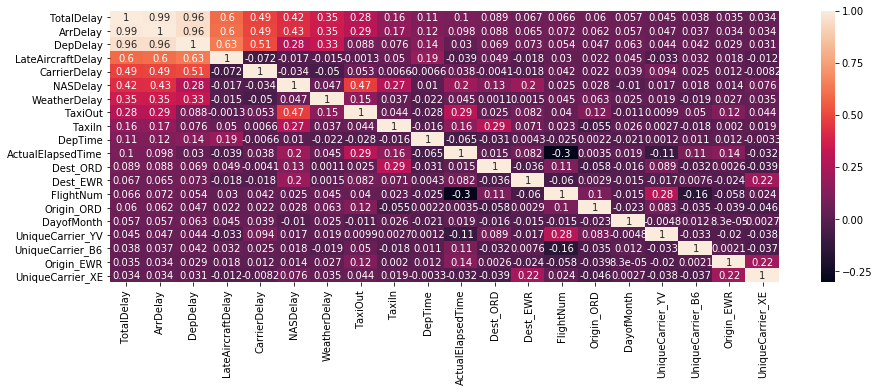

In [79]:
fig = plt.figure(figsize=(15,5))
fig = sns.heatmap(corr_col_corr,annot=True)

__I see both destination/origin features for ORD and EWR (Ordway Int'l in Chicago, IL; Newark Liberty Int'l in Newark, NJ), and carriers YV, B6, and XE (Mesa Airlines, JetBlue, and ExpressJet). Further interesting research could be to dig into the statistics for each of those airports and airlines to see why they are so highly correlated with delays, and how they compare to other airports and airlines.__

In [112]:
interesting_features = ['TaxiOut','TaxiIn','DepTime','ActualElapsedTime',
                        'Dest_ORD','Dest_EWR','FlightNum','Origin_ORD',
                        'DayofMonth','UniqueCarrier_YV','UniqueCarrier_B6','Origin_EWR','UniqueCarrier_XE',
                        'UniqueCarrier_OH','CRSDepTime','UniqueCarrier_OO','Dest_JFK','Origin_JFK'
                       ]

In [113]:
import copy
int_plus_TotalDelay = copy.deepcopy(interesting_features)
int_plus_TotalDelay.append('TotalDelay')
#int_plus_TotalDelay.append('log_TotalDelay')

# Create a copy of the dataframe that's just these variables--it'll be easier to manage/manipulate
interesting_df = all_delay_df[int_plus_TotalDelay]
interesting_df.head()

,TaxiOut,TaxiIn,DepTime,ActualElapsedTime,Dest_ORD,Dest_EWR,FlightNum,Origin_ORD,DayofMonth,UniqueCarrier_YV,UniqueCarrier_B6,Origin_EWR,UniqueCarrier_XE,UniqueCarrier_OH,CRSDepTime,UniqueCarrier_OO,Dest_JFK,Origin_JFK,TotalDelay
0,15.0,5.0,1126.0,75.0,0,0,2717,0,3,0,0,0,0,0,1045,0,0,0,41.0
1,6.0,3.0,2017.0,106.0,0,0,965,0,3,0,0,0,0,0,1955,0,0,0,35.0
2,10.0,3.0,1859.0,86.0,0,0,1712,0,3,0,0,0,0,0,1825,0,0,0,25.0
3,14.0,3.0,1256.0,62.0,0,0,294,0,3,0,0,0,0,0,1240,0,0,0,23.0
4,5.0,4.0,1925.0,55.0,0,0,2776,0,3,0,0,0,0,0,1900,0,0,0,20.0


In [114]:
# Y is the target variable
Y = interesting_df['TotalDelay'] #interesting_df['log_TotalDelay']

# X is the feature set.
X = interesting_df[interesting_features]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 157238
The number of observations in test set is 39310


In [115]:
linear = LinearRegression()
kfold_xval(linear,X_train,y_train,num_folds=10)

Cross-validation using 10 folds
[0.14439259 0.13498683 0.14944372 0.1449236  0.15278725 0.1502658
 0.15012046 0.13931111 0.15390885 0.12485141]


R-squared of the model on the training set is: 0.14472177247250861
-----Test set statistics-----
R-squared of the model on the test set is: 0.15711169504018763
Mean absolute error of the prediction is: 34.45779340789759
Mean squared error of the prediction is: 3216.988279037284
Root mean squared error of the prediction is: 56.71850032429705
Mean absolute percentage error of the prediction is: 136.93682230621516


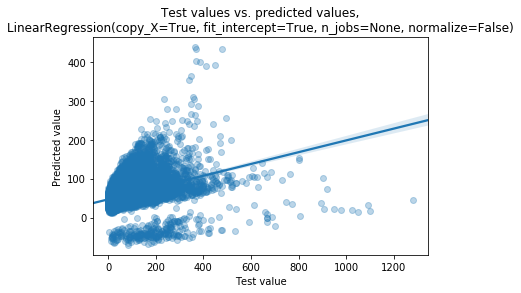

In [116]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

In [117]:
# We are making predictions here
y_predictions = linear.predict(X)

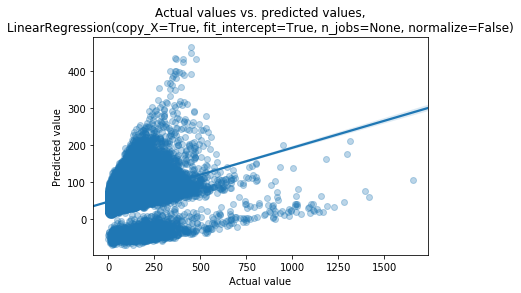

In [118]:
# Setting the alpha low helps us understand whether there is a concentration of observations
#  at a particular point, or if it is an outlier
    ax = sns.regplot(Y,y_predictions,scatter_kws={'alpha':0.3})
    ax.set(xlabel='Actual value', ylabel='Predicted value',title='Actual values vs. predicted values,\n{}'.format(str(linear)))
    plt.show()

In [119]:
print("R-squared of the model on the full dataset is: {}".format(linear.score(X,Y)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y, y_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(Y, y_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y, y_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y - y_predictions) / Y)) * 100))


R-squared of the model on the full dataset is: 0.14725870071942426
Mean absolute error of the prediction is: 34.32117122943555
Mean squared error of the prediction is: 3194.7801395263737
Root mean squared error of the prediction is: 56.52238618040089
Mean absolute percentage error of the prediction is: 137.48728675023202


This is probably not the best dataset for this challenge--the most significantly-correlated features to the target, Total Delay time, are themselves measures of various kinds of delay. But this certainly looks great! :)

So let's finish this and see what we can do with K Nearest Neighbors.

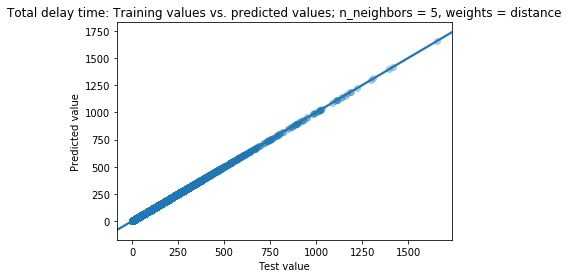

Training Accuracy: 0.87 (+/- 0.04)


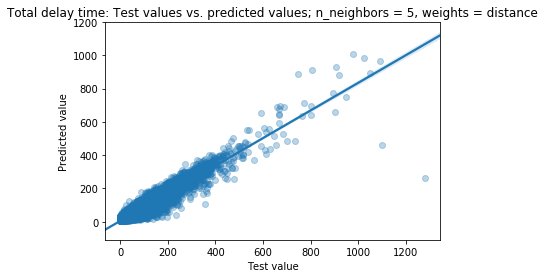

Test Accuracy: 0.78 (+/- 0.05)


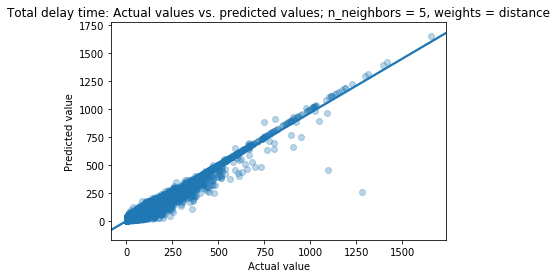

Accuracy: 0.78 (+/- 0.14)


In [120]:
build_test_knn_regressor(X,Y,X_train,y_train,X_test,y_test,weights='distance')

## At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

So this was a shock--I originally had some of the \*Delay features included, which led to both models performing really well, and with nearly identical accuracy (97% or so), but with the linear regression model slightly outperforming the KNN model. After a discussion with my mentor about [data leakage](https://towardsdatascience.com/data-leakage-part-i-think-you-have-a-great-machine-learning-model-think-again-ad44921fbf34), I removed those features and tried again, ending with the results above, where the KNN model is the clear winner.

I'm trying to decide which would be better with the outliers of a dataset. I want to say maybe the KNN regressor model would do a better job of bending to reach them than the straight line of OLS regression--but that seems as if it could also a detractor, leading the KNN model to make more erratic predictions. I think the distribution of the data must play a part in which model would perform better here. 

In this case it seems like KNN's ability to venture away from a straight line and follow the distribution of the data must be helpful. Plots of the linear regression model show an odd split between values where the model underperforms and predicts values less than zero, and values that are closer to the line of best fit. The linear model plot of actual vs predicted values also shows some amount of heteroscedasticity that is not present in the KNN model's plots. There are still some outliers in the KNN model's plot, but not nearly as many.

The R-squared values for the two also demonstrate the marked difference: 14% for the OLS model vs. 78% for KNN.

### Notes
[Types of delay](https://aspmhelp.faa.gov/index.php/Types_of_Delay) are described here.